In [9]:
import ast
import os
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

# Get list of all CSV files in the directory
list_of_files = list(Path("../logs/performance").rglob("*.csv"))

# Find the latest file
latest_file = max(list_of_files, key=os.path.getctime)

# Load the latest CSV file into a DataFrame
df_latest = pd.read_csv(latest_file)
# format: "timestamp", "category", "test_name","query", "scenario",
# "execution_time""cache_hits", "cache_misses", "cache_size","results_consistent",

print(df_latest)

# First check the unique category values to see what we're working with
print("Unique categories:", df_latest["category"].unique())

# Strip whitespace and normalize the category column
df_latest["category"] = df_latest["category"].str.strip()

                timestamp              category                  test_name  \
0     2025-02-26 12:13:09  base_keyword_queries           simple_keyword_1   
1     2025-02-26 12:13:09  base_keyword_queries           simple_keyword_1   
2     2025-02-26 12:13:09  base_keyword_queries           simple_keyword_1   
3     2025-02-26 12:13:09  base_keyword_queries           simple_keyword_1   
4     2025-02-26 12:13:09  base_keyword_queries           simple_keyword_1   
...                   ...                   ...                        ...   
7321  2025-02-26 12:47:57    mixed_combinations  mixed_combination_AND_505   
7322  2025-02-26 12:47:57    mixed_combinations  mixed_combination_AND_505   
7323  2025-02-26 12:47:57    mixed_combinations  mixed_combination_AND_505   
7324  2025-02-26 12:47:57    mixed_combinations  mixed_combination_AND_505   
7325  2025-02-26 12:47:57    mixed_combinations  mixed_combination_AND_505   

                                                  query        

In [10]:
# Filter the DataFrame by category with stripped values
base_keyword_queries = df_latest[df_latest["category"] == "base_keyword_queries"]
base_keyword_queries = base_keyword_queries[base_keyword_queries["results_consistent"]]
base_percentile_queries = df_latest[df_latest["category"] == "base_percentile_queries"]
base_percentile_queries = base_percentile_queries[
    base_percentile_queries["results_consistent"]
].reset_index()
keyword_combinations = df_latest[df_latest["category"] == "keyword_combinations"]
keyword_combinations = keyword_combinations[
    keyword_combinations["results_consistent"]
].reset_index()
percentile_combinations = df_latest[df_latest["category"] == "percentile_combinations"]
percentile_combinations = percentile_combinations[
    percentile_combinations["results_consistent"]
].reset_index()
mixed_combinations = df_latest[df_latest["category"] == "mixed_combinations"]
mixed_combinations = mixed_combinations[mixed_combinations["results_consistent"]].reset_index()

# Print to verify the filtering worked
print("\nCounts after fixing whitespace:")
print("Base keyword queries:", len(base_keyword_queries))
print("Base percentile queries:", len(base_percentile_queries))
print("Keyword combinations:", len(keyword_combinations))
print("Percentile combinations:", len(percentile_combinations))
print("Mixed combinations:", len(mixed_combinations))


Counts after fixing whitespace:
Base keyword queries: 66
Base percentile queries: 24
Keyword combinations: 2736
Percentile combinations: 66
Mixed combinations: 2604


Text(0.5, 1.0, 'Percentile queries with two terms')

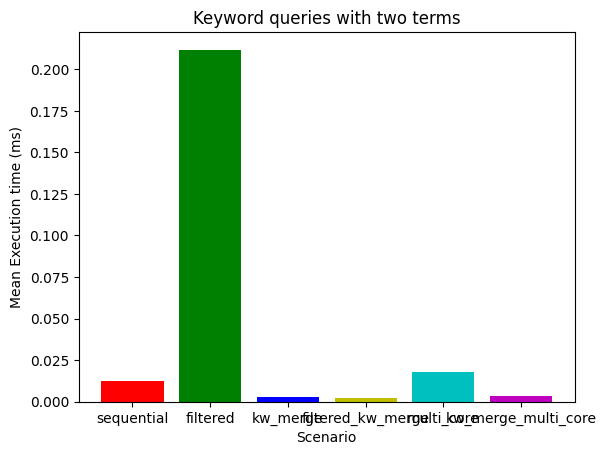

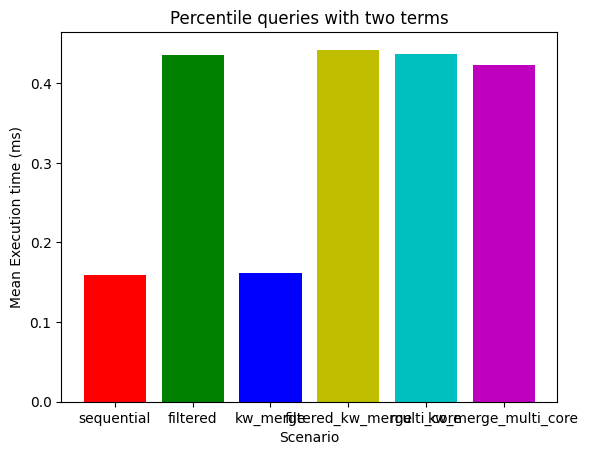

In [11]:
# compare the execution time of the keyword queries with two terms
# and the execution time of the percentile queries with two terms
# with different scenarios in two separate plots with bar charts

plt.figure()

# get the unique scenarios
scenarios = base_keyword_queries["scenario"].unique()
colors = ["r", "g", "b", "y", "c", "m", "k"]

for i, scenario in enumerate(scenarios):
    df_keyword = keyword_combinations[keyword_combinations["scenario"] == scenario]
    df_keyword = df_keyword[df_keyword["num_terms"] == 2]

    plt.bar(
        scenario,
        df_keyword["execution_time"].mean(),
        color=colors[i],
    )

plt.xlabel("Scenario")
plt.ylabel("Mean Execution time (ms)")
plt.title("Keyword queries with two terms")

plt.figure()

for i, scenario in enumerate(scenarios):
    df_percentile = percentile_combinations[percentile_combinations["scenario"] == scenario]
    df_percentile = df_percentile[df_percentile["num_terms"] == 2]

    plt.bar(
        scenario,
        df_percentile["execution_time"].mean(),
        color=colors[i],
    )

plt.xlabel("Scenario")
plt.ylabel("Mean Execution time (ms)")
plt.title("Percentile queries with two terms")

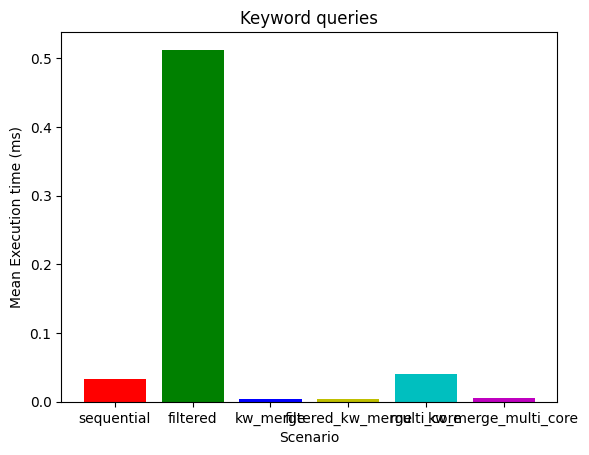

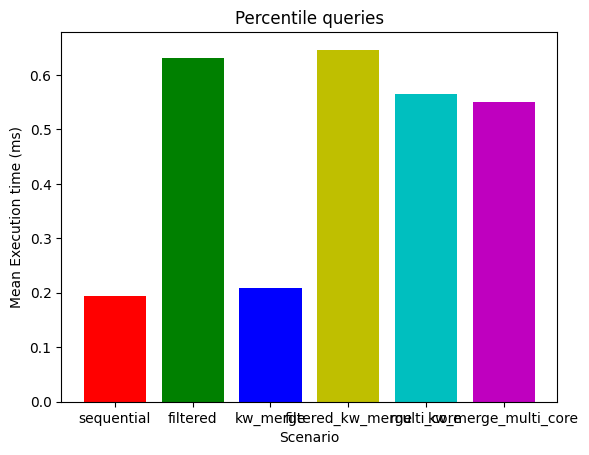

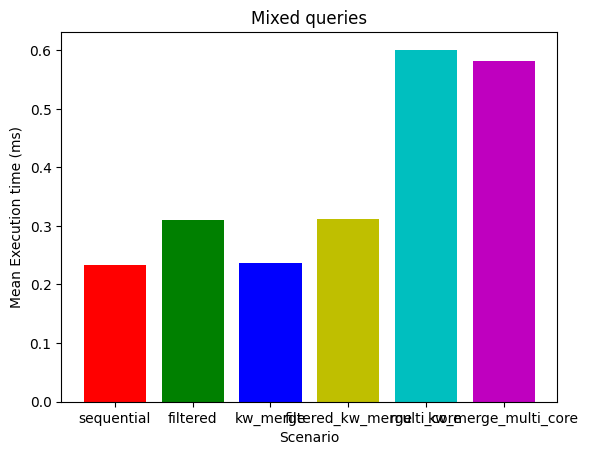

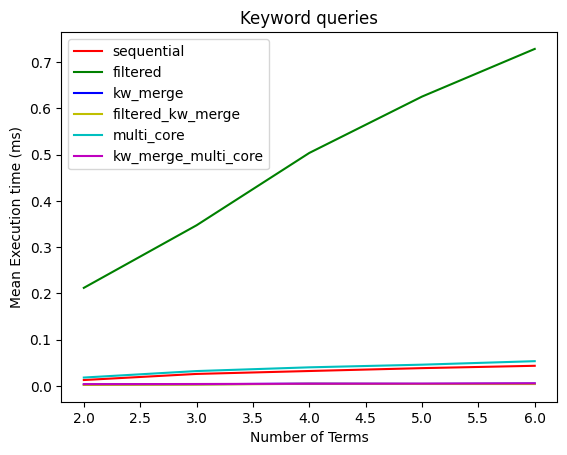

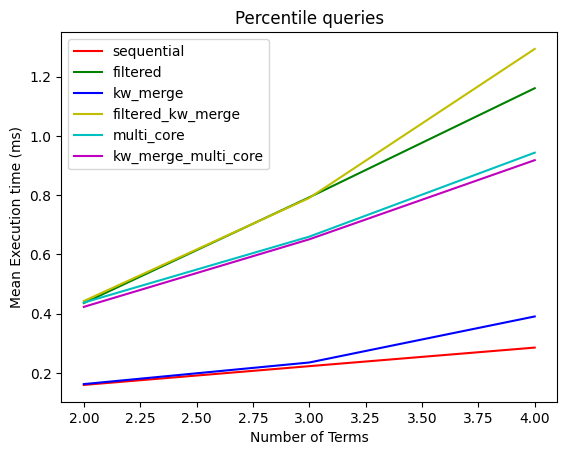

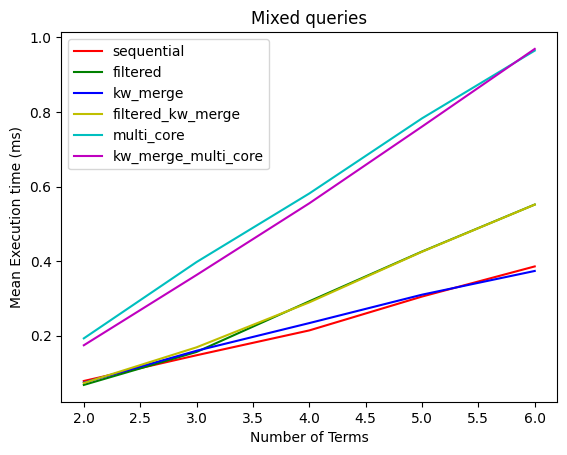

In [12]:
# compare the execution time of the keyword queries
# and the execution time of the percentile queries
# with different scenarios in two separate plots with bar charts

plt.figure()

# get the unique scenarios
scenarios = base_keyword_queries["scenario"].unique()
colors = ["r", "g", "b", "y", "c", "m", "k"]

for i, scenario in enumerate(scenarios):
    df_keyword = keyword_combinations[keyword_combinations["scenario"] == scenario]

    plt.bar(
        scenario,
        df_keyword["execution_time"].mean(),
        color=colors[i],
    )

plt.xlabel("Scenario")
plt.ylabel("Mean Execution time (ms)")
plt.title("Keyword queries")

plt.figure()

for i, scenario in enumerate(scenarios):
    df_percentile = percentile_combinations[percentile_combinations["scenario"] == scenario]

    plt.bar(
        scenario,
        df_percentile["execution_time"].mean(),
        color=colors[i],
    )

plt.xlabel("Scenario")
plt.ylabel("Mean Execution time (ms)")
plt.title("Percentile queries")

plt.figure()

for i, scenario in enumerate(scenarios):
    df_mixed = mixed_combinations[mixed_combinations["scenario"] == scenario]

    plt.bar(
        scenario,
        df_mixed["execution_time"].mean(),
        color=colors[i],
    )

plt.xlabel("Scenario")
plt.ylabel("Mean Execution time (ms)")
plt.title("Mixed queries")

# compare the execution time of the keyword queries and percentile queries
# per number of terms in the query
# with different scenarios as separate lines in the same plot

plt.figure()

for i, scenario in enumerate(scenarios):
    df_keyword = keyword_combinations[keyword_combinations["scenario"] == scenario]

    mean_execution_times = df_keyword.groupby("num_terms")["execution_time"].mean()
    plt.plot(
        mean_execution_times.index,
        mean_execution_times.values,
        label=scenario,
        color=colors[i],
    )

plt.xlabel("Number of Terms")
plt.ylabel("Mean Execution time (ms)")
plt.title("Keyword queries")
plt.legend()

plt.figure()

for i, scenario in enumerate(scenarios):
    df_percentile = percentile_combinations[percentile_combinations["scenario"] == scenario]

    mean_execution_times = df_percentile.groupby("num_terms")["execution_time"].mean()
    plt.plot(
        mean_execution_times.index,
        mean_execution_times.values,
        label=scenario,
        color=colors[i],
    )

plt.xlabel("Number of Terms")
plt.ylabel("Mean Execution time (ms)")
plt.title("Percentile queries")
plt.legend()

# mixed combinations
plt.figure()

for i, scenario in enumerate(scenarios):
    df_mixed = mixed_combinations[mixed_combinations["scenario"] == scenario]

    mean_execution_times = df_mixed.groupby("num_terms")["execution_time"].mean()
    plt.plot(
        mean_execution_times.index,
        mean_execution_times.values,
        label=scenario,
        color=colors[i],
    )

plt.xlabel("Number of Terms")
plt.ylabel("Mean Execution time (ms)")
plt.title("Mixed queries")
plt.legend()

Text(0.5, 1.0, 'Keyword queries with two terms')

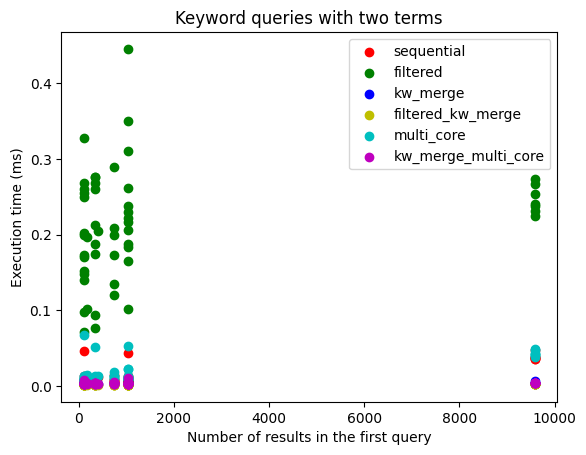

In [13]:
# plot the timing of the keyword queries with two terms
# to compare the different scenarios over the number of results in the first query (x-axis)

# looks how the filter works with different sizes


def find_results(id_str: str, df: pd.DataFrame) -> list[int]:
    return df[df["id_str"] == id_str]["results"].values[0]


plt.figure()

# get the unique scenarios
scenarios = base_keyword_queries["scenario"].unique()
colors = ["r", "g", "b", "y", "c", "m", "k"]

for i, scenario in enumerate(scenarios):
    df = keyword_combinations[keyword_combinations["scenario"] == scenario]
    scenario_base_keyword_queries = base_keyword_queries[
        base_keyword_queries["scenario"] == scenario
    ]
    df = df[df["num_terms"] == 2]

    df["first_query_id"] = df["ids"].apply(lambda x: ast.literal_eval(x)[0]["keyword_id"])
    df["first_query_results"] = df["first_query_id"].apply(
        lambda x, scenario_df=scenario_base_keyword_queries: find_results(x, scenario_df)
    )
    df["first_query_num_results"] = df["first_query_results"].apply(lambda x: len(x))

    plt.scatter(
        df["first_query_num_results"], df["execution_time"], label=scenario, color=colors[i]
    )

plt.legend()

plt.xlabel("Number of results in the first query")
plt.ylabel("Execution time (ms)")
plt.title("Keyword queries with two terms")

Text(0.5, 1.0, 'Percentile queries with two terms')

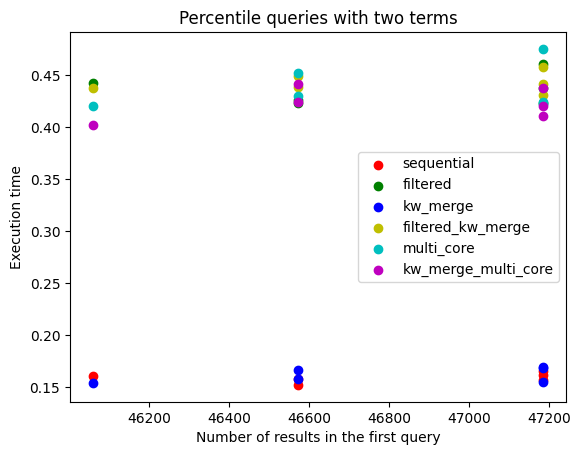

In [14]:
# plot the timing of the percentile queries with two terms
# to compare the different scenarios over the number of results in the first query (x-axis)

plt.figure()

# get the unique scenarios
scenarios = base_percentile_queries["scenario"].unique()

for i, scenario in enumerate(scenarios):
    df = percentile_combinations[percentile_combinations["scenario"] == scenario]
    scenario_base_percentile_queries = base_percentile_queries[
        base_percentile_queries["scenario"] == scenario
    ]
    df = df[df["num_terms"] == 2]

    df["first_query_id"] = df["ids"].apply(lambda x: ast.literal_eval(x)[0]["percentile_id"])
    df["first_query_results"] = df["first_query_id"].apply(
        lambda x, scenario_df=scenario_base_percentile_queries: find_results(x, scenario_df)
    )
    df["first_query_num_results"] = df["first_query_results"].apply(lambda x: len(x))

    plt.scatter(
        df["first_query_num_results"], df["execution_time"], label=scenario, color=colors[i]
    )

plt.legend()
plt.xlabel("Number of results in the first query")
plt.ylabel("Execution time")
plt.title("Percentile queries with two terms")

Text(0.5, 1.0, 'Base Queries Execution Time')

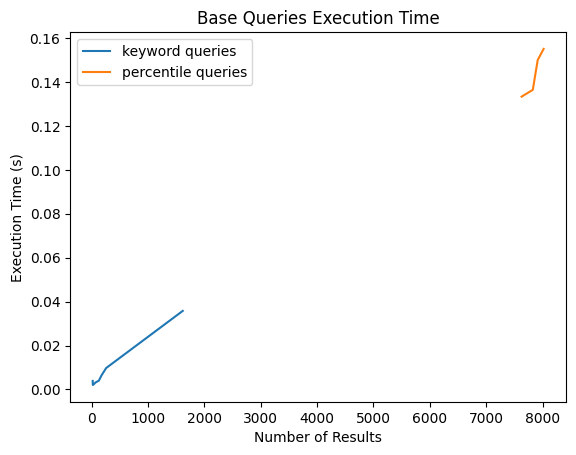

In [15]:
# compare kw vs pp time for base queries (for cost based optimization)

# relevant columns: execution_time number_of_results (seneario is irrelevant for base queries)
plt.figure()

df = base_keyword_queries.groupby("num_results")["execution_time"].mean()

plt.plot(df.index, df, label="keyword queries")

df = base_percentile_queries.groupby("num_results")["execution_time"].mean()

plt.plot(df.index, df, label="percentile queries")

plt.xlabel("Number of Results")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.title("Base Queries Execution Time")

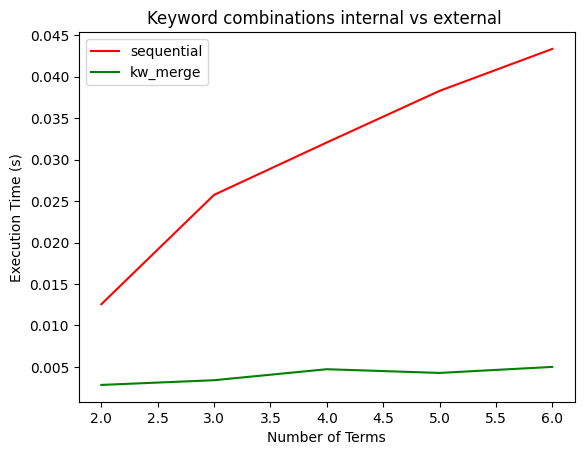

In [16]:
# compare kw combinations internal and external ie: kw(a) AND kw(b) vs kw(a AND b)
# for possible optimization

# category: keyword_combinations and keyword_combinations_internal

# relevant columns: execution_time, num of results,
#   scenario for internal irrelevant for external relevant


plt.figure()

kw = keyword_combinations

# plot per scenario

scenarios = ["sequential", "kw_merge"]
colors = ["r", "g", "b", "y", "c", "m", "k"]

for i, scenario in enumerate(scenarios):
    df = kw[kw["scenario"] == scenario].groupby("num_terms")["execution_time"].mean()

    plt.plot(df.index, df, label=scenario, color=colors[i])


plt.xlabel("Number of Terms")

plt.ylabel("Execution Time (s)")

plt.title("Keyword combinations internal vs external ")

plt.legend()